### Introduction



Welcome to you for this Cycle GAN kernel. Coded by me Sémi Ben Hsan (SBH) .Machine Learning Intern at TalTech - Tallinn University of Technology . This kernel includes and advanced implementation of Cycle GAN with some visuals and tricks to improve the model performance , programmed in a professional way ( The SBH style ) and explained in detail . I am waiting for your votes, opinions and comments ... If you use parts of this notebook in your scripts/notebooks, giving some kind of credit would be very much appreciated :) You can for instance link back to this notebook. Thanks!


### Plan

0. Importations
1. Redefining Dataset
2. Generator Architecture
3. Model Blocks
4. Full Generator
5. Discriminator Architecture
6.  Discriminator Code
7. Discriminator Loss
8. Generator Loss

  8.1 Adversarial Loss

  8.2 Identity loss

  8.3 Cycle Consistency Loss

  8.4 Full Generator Loss

9. CycleGAN Training
10. Main 

  10.1 Loading Data

  10.2 Visuals

  10.3.Prepare Model
11. Tricks And improvements

### 0. IMPORTATIONS

In [ ]:
import glob
import random
import os
from PIL import Image
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

### 1. Redefining Dataset

PyTorch supports two classes, which are torch.utils.data.Dataset and torch.utils.data.DataLoader, to facilitate loading dataset and to make mini-batch without large effort. Let's use them now as below  in order to load our Monet and Real Photos 

In [ ]:
class ImageDataset(Dataset):
    def __init__(self,MONET_FILENAMES,PHOTO_FILENAMES, transform=None): 
        self.transform = transform
        self.PHOTO_FILENAMES = PHOTO_FILENAMES
        self.MONET_FILENAMES = MONET_FILENAMES
        if len(self.MONET_FILENAMES) > len (self.PHOTO_FILENAMES):
            self.MONET_FILENAMES, self.PHOTO_FILENAMES = self.PHOTO_FILENAMES, self.MONET_FILENAMES
        self.new_perm()

    def new_perm(self):
        self.randperm = torch.randperm(len(self.PHOTO_FILENAMES))[:len(self.MONET_FILENAMES)]
    def __getitem__(self, index):     
        item_MONET_FILENAMES = self.transform(Image.open(self.MONET_FILENAMES[index % len(self.MONET_FILENAMES)]))
        item_PHOTO_FILENAMES = self.transform(Image.open(self.PHOTO_FILENAMES[self.randperm[index]]))
        if item_MONET_FILENAMES.shape[0] != 3: 
            item_MONET_FILENAMES = item_MONET_FILENAMES.repeat(3, 1, 1)
        if item_PHOTO_FILENAMES.shape[0] != 3: 
            item_PHOTO_FILENAMES = item_PHOTO_FILENAMES.repeat(3, 1, 1)
        if index == len(self) - 1:
            self.new_perm()
        return (item_MONET_FILENAMES - 0.5) * 2, (item_PHOTO_FILENAMES - 0.5) * 2

    def __len__(self):
        return min(len(self.MONET_FILENAMES), len(self.PHOTO_FILENAMES))

### 2. Generator Architecture 


The generator is responsible for generating images from a specific domain. CycleGAN architecture has two generators, in this context we will have one generator that will take photos and generate Monet paints, and the other generator will take Monet paintings and generate photos.

Bellow, we have the architecture of the original CycleGAN generator , ours have some changes to improve performance on this task.


Diagram of a CycleGAN generator: composed of encoding blocks, residual blocks, and then decoding blocks.

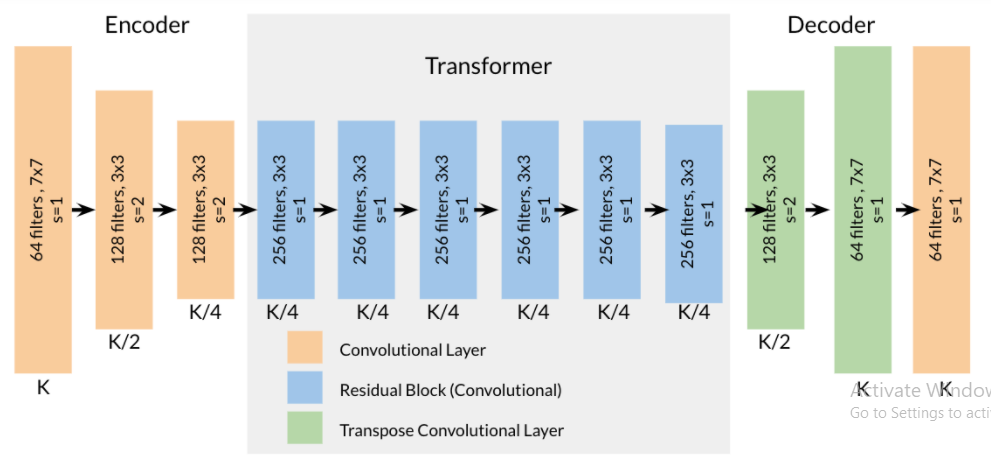

### 3 . Model Blocks


Here we the building blocks of our models:

ContractingBlock (Encoder) block: Apply convolutional filters while also reducing data resolution and increasing features.

Expanding (Decoder) block: Apply convolutional filters while also increasing data resolution and decreasing features.

Residual block: Apply convolutional filters to find relevant data patterns and keeps features constant. We will use here some skip connections in order to get Residual blocks

Let's go to the implementation .... 
Feel free to ask about any line of code

In [ ]:
class ResidualBlock(nn.Module): 
    def __init__(self, input_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, input_channels, kernel_size=3, padding=1, padding_mode='reflect')
        self.conv2 = nn.Conv2d(input_channels, input_channels, kernel_size=3, padding=1, padding_mode='reflect')
        self.instancenorm = nn.InstanceNorm2d(input_channels)
        self.activation = nn.ReLU()

    def forward(self, x):
        original_x = x.clone()
        x = self.conv1(x)
        x = self.instancenorm(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.instancenorm(x)
        return original_x + x

In [ ]:
class ContractingBlock(nn.Module): 
    def __init__(self, input_channels, use_bn=True, kernel_size=3, activation='relu'):
        super(ContractingBlock, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, input_channels * 2, kernel_size=kernel_size, padding=1, stride=2, padding_mode='reflect')
        self.activation = nn.ReLU() if activation == 'relu' else nn.LeakyReLU(0.2)
        if use_bn:
            self.instancenorm = nn.InstanceNorm2d(input_channels * 2)
        self.use_bn = use_bn

    def forward(self, x):
        x = self.conv1(x)
        if self.use_bn:
            x = self.instancenorm(x)
        x = self.activation(x)
        return x

class ExpandingBlock(nn.Module):

    def __init__(self, input_channels, use_bn=True):
        super(ExpandingBlock, self).__init__()
        self.conv1 = nn.ConvTranspose2d(input_channels, input_channels // 2, kernel_size=3, stride=2, padding=1, output_padding=1)
        if use_bn:
            self.instancenorm = nn.InstanceNorm2d(input_channels // 2)
        self.use_bn = use_bn
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        if self.use_bn:
            x = self.instancenorm(x)
        x = self.activation(x)
        return x

This layer will be on the top and in the final layers of the models .. It's role is to map the input matrix to desired output channels

In [ ]:
class FeatureMapBlock(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(FeatureMapBlock, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=7, padding=3, padding_mode='reflect')

    def forward(self, x):
        x = self.conv(x)
        return x

### 4 . Full Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self, input_channels, output_channels, hidden_channels=64):
        super(Generator, self).__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels)
        self.contract2 = ContractingBlock(hidden_channels * 2)
        res_mult = 4
        self.res0 = ResidualBlock(hidden_channels * res_mult)
        self.res1 = ResidualBlock(hidden_channels * res_mult)
        self.res2 = ResidualBlock(hidden_channels * res_mult)
        self.res3 = ResidualBlock(hidden_channels * res_mult)
        self.res4 = ResidualBlock(hidden_channels * res_mult)
        self.res5 = ResidualBlock(hidden_channels * res_mult)
        self.res6 = ResidualBlock(hidden_channels * res_mult)
        self.res7 = ResidualBlock(hidden_channels * res_mult)
        self.res8 = ResidualBlock(hidden_channels * res_mult)
        self.expand2 = ExpandingBlock(hidden_channels * 4)
        self.expand3 = ExpandingBlock(hidden_channels * 2)
        self.downfeature = FeatureMapBlock(hidden_channels, output_channels)
        self.tanh = torch.nn.Tanh()

    def forward(self, x):
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.res0(x2)
        x4 = self.res1(x3)
        x5 = self.res2(x4)
        x6 = self.res3(x5)
        x7 = self.res4(x6)
        x8 = self.res5(x7)
        x9 = self.res6(x8)
        x10 = self.res7(x9)
        x11 = self.res8(x10)
        x12 = self.expand2(x11)
        x13 = self.expand3(x12)
        xn = self.downfeature(x13)
        return self.tanh(xn)

### 5. Discriminator Architecture

The discriminator is responsible for differentiating real images from images that have been generated by a generator model.

Bellow, we have the architecture of the original CycleGAN discriminator, again, ours have some changes to improve performance on this task.

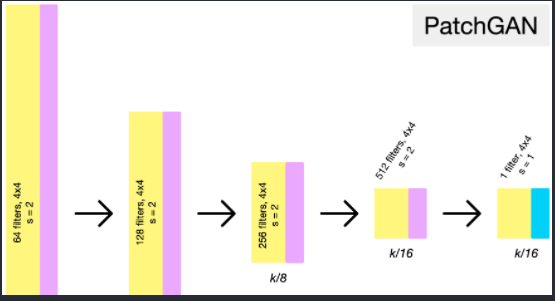

### 6 . Discriminator Code

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_channels, hidden_channels=64):
        super(Discriminator, self).__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels, use_bn=False, kernel_size=4, activation='lrelu')
        self.contract2 = ContractingBlock(hidden_channels * 2, kernel_size=4, activation='lrelu')
        self.contract3 = ContractingBlock(hidden_channels * 4, kernel_size=4, activation='lrelu')
        self.final = nn.Conv2d(hidden_channels * 8, 1, kernel_size=1)

    def forward(self, x):
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.contract3(x2)
        xn = self.final(x3)
        return xn

### 7. Discriminator Loss 

First, we will going to be implementing the discriminator loss ... Like a classique discriminator loss in a Simple GAN

In [ ]:
def get_disc_loss(real_X, fake_X, disc_X, adv_criterion):
 
    disc_fake_X_hat = disc_X(fake_X.detach()) # Detach generator in order the fix it's params while training the discriminator
    disc_fake_X_loss = adv_criterion(disc_fake_X_hat, torch.zeros_like(disc_fake_X_hat))
    disc_real_X_hat = disc_X(real_X)
    disc_real_X_loss = adv_criterion(disc_real_X_hat, torch.ones_like(disc_real_X_hat))
    disc_loss = (disc_fake_X_loss + disc_real_X_loss) / 2
    return disc_loss

### 8 . Generator Loss

8.1  Adversarial Loss

The first component of the generator's loss I'm going to implement is its adversarial loss 

In [ ]:
def get_gen_adversarial_loss(real_X, disc_Y, gen_XY, adv_criterion):
    fake_Y = gen_XY(real_X)
    disc_fake_Y_hat = disc_Y(fake_Y)
    adversarial_loss = adv_criterion(disc_fake_Y_hat, torch.ones_like(disc_fake_Y_hat))
    return adversarial_loss, fake_Y

8.2 Identity loss

We'll want to measure the change in an image when you pass the generator an example from the target domain instead of the input domain it's expecting. The output should be the same as the input since it is already of the target domain class. For example, if you put a Monet Photo through a PHOTO -> MONET generator, We'll expect the output to be the same Monet PHOTO because nothing needed to be transformed. It's already a MONET PHOTO! You don't want your generator to be transforming it into any other thing, so you want to encourage this behavior. In encouraging this identity mapping, this will help also to  properly preserve the colors of an image, even when the expected input (here, a MONET PHOTO) was put in. 

In [ ]:
def get_identity_loss(real_X, gen_YX, identity_criterion):
    identity_X = gen_YX(real_X)
    identity_loss = identity_criterion(identity_X, real_X)
    return identity_loss, identity_X

8.3 Cycle Consistency Loss

This is used to ensure that when you put an image through one generator, that if it is then transformed back into the input class using the opposite generator, the image is the same as the original input image.Since I've already generated a fake image for the adversarial part,I can now pass that fake image back to produce a full cycle—this loss will encourage the cycle to preserve as much information as possible.

In [ ]:
def get_cycle_consistency_loss(real_X, fake_Y, gen_YX, cycle_criterion):
    cycle_X = gen_YX(fake_Y)
    cycle_loss = cycle_criterion(cycle_X, real_X)
    return cycle_loss, cycle_X

8.4 Full Generator Loss


Finally, I can put it all together!

In [ ]:
def get_gen_loss(real_P, real_M, gen_PM, gen_MP, disc_P, disc_M, adv_criterion, identity_criterion, cycle_criterion, lambda_identity=0.1, lambda_cycle=10):
    
    adv_loss_MP, fake_P = get_gen_adversarial_loss(real_M, disc_P, gen_MP, adv_criterion)
    adv_loss_PM, fake_M = get_gen_adversarial_loss(real_P, disc_M, gen_PM, adv_criterion)
    gen_adversarial_loss = adv_loss_MP + adv_loss_PM

    identity_loss_P, identity_P = get_identity_loss(real_P, gen_MP, identity_criterion)
    identity_loss_M, identity_M = get_identity_loss(real_M, gen_PM, identity_criterion)
    gen_identity_loss = identity_loss_M + identity_loss_P

    cycle_loss_MP, cycle_P = get_cycle_consistency_loss(real_P, fake_M, gen_MP, cycle_criterion)
    cycle_loss_PM, cycle_M = get_cycle_consistency_loss(real_M, fake_P, gen_PM, cycle_criterion)
    gen_cycle_loss = cycle_loss_PM + cycle_loss_PM

    gen_loss = lambda_identity * gen_identity_loss + lambda_cycle * gen_cycle_loss + gen_adversarial_loss

    return gen_loss, fake_P, fake_M

### 9. CycleGAN Training

Lastly, I can now train  the model and see some of my Monet PHOTO  and some that might not quite look like either! Note that this training will take a long time, so i will desactivate it because i have a very low computational ressources . And I can't wait kaggle TPU xD I'm a bit moody guys xD


In order to have a better train performance I'll introduce a learning rate scheduler the "ReduceLROnPlateau" scheduler. 

In [ ]:
from skimage import color
import numpy as np
from tqdm import tqdm
plt.rcParams["figure.figsize"] = (10, 10)


def train(save_model=False):
    mean_generator_loss = 0
    mean_discriminator_loss = 0
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    cur_step = 0
    
    scheduler_discP = torch.optim.lr_scheduler.ReduceLROnPlateau(disc_P_opt,factor=0.1, patience=5, 
                                                       verbose=True)
    scheduler_discM = torch.optim.lr_scheduler.ReduceLROnPlateau(disc_M_opt,factor=0.1, patience=5, 
                                                       verbose=True)
    scheduler_gen = torch.optim.lr_scheduler.ReduceLROnPlateau(gen_opt,factor=0.1, patience=5, 
                                                       verbose=True)
    
    for epoch in range(n_epochs):
        losses_P = []
        losses_M = []
        losses_gen = []
        for real_P,real_M in tqdm(dataloader):
            real_P = nn.functional.interpolate(real_P, size=target_shape)
            real_M = nn.functional.interpolate(real_M, size=target_shape)
            cur_batch_size = len(real_P)
            real_P = real_P
            real_M = real_M
        

            ### Update discriminator A ###
            disc_P_opt.zero_grad() # Zero out the gradient before backpropagation
            with torch.no_grad():
                fake_P = gen_MP(real_M)
            disc_P_loss = get_disc_loss(real_P, fake_P, disc_P, adv_criterion)
            disc_P_loss.backward(retain_graph=True) # Update gradients
            disc_P_opt.step() # Update optimizer
            losses_P.append(disc_P_loss.item())

            ### Update discriminator B ###
            disc_M_opt.zero_grad() # Zero out the gradient before backpropagation
            with torch.no_grad():
                fake_M = gen_PM(real_P)
            disc_M_loss = get_disc_loss(real_M, fake_M, disc_M, adv_criterion)
            disc_M_loss.backward(retain_graph=True) # Update gradients
            disc_M_opt.step() # Update optimizer
            losses_M.append(disc_M_loss.item())

            ### Update generator ###
            gen_opt.zero_grad()
            gen_loss, fake_P, fake_M = get_gen_loss(
                real_P, real_M, gen_PM, gen_MP, disc_P, disc_M, adv_criterion, recon_criterion, recon_criterion
            )
            gen_loss.backward() # Update gradients
            gen_opt.step() # Update optimizer
            losses_gen.append(gen_loss.item())
        mean_loss_disc_M = sum(losses_M)/len(losses_M)
        mean_loss_disc_P = sum(losses_P)/len(losses_P)
        mean_loss_gen = sum(losses_gen)/len(losses_gen)
        scheduler_discP.step(mean_loss_disc_P)
        scheduler_discM.step(mean_loss_disc_M) 
        scheduler_gen.step(mean_loss_gen) 

### 10. Main

10.1. Loading Data

In [ ]:
import os
BASE_PATH = "../input/gan-getting-started/"
def prepare_Paths (BASE_PATH) :  # a function to prepare the path names of MONET/Real photos
    MONET_PATH = os.path.join(BASE_PATH, "monet_jpg")
    PHOTO_PATH = os.path.join(BASE_PATH, "photo_jpg")
    return MONET_PATH,PHOTO_PATH

In [ ]:
MONET_PATH,PHOTO_PATH  = prepare_Paths (BASE_PATH)

In [ ]:
def Prepare_list_names(MONET_PATH,PHOTO_PATH) :  # A function to prepare two lists of MONET PHOTO names
    MONET_FILENAMES = sorted(glob.glob(os.path.join(str(MONET_PATH) + '/*.jpg')))
    PHOTO_FILENAMES = sorted(glob.glob(os.path.join(str(PHOTO_PATH) + '/*.jpg')))
    return MONET_FILENAMES,PHOTO_FILENAMES
MONET_FILENAMES,PHOTO_FILENAMES = Prepare_list_names(MONET_PATH,PHOTO_PATH)

In [ ]:
# The set of transformations to do in order to make some data augmentation to help the model avoiding the overfitting 
target_shape = 256
load_shape = 286
transform = transforms.Compose([
    transforms.Resize(load_shape),
    transforms.RandomCrop(target_shape),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

import torchvision
dataset = ImageDataset(MONET_FILENAMES,PHOTO_FILENAMES, transform=transform)

10.2. Visuals

In [ ]:
import cv2
def print_folder_statistics(path): # a function to make some stats on the folder of images 
    d_image_sizes = {} 
    for image_name in os.listdir(path):
        image = cv2.imread(os.path.join(path, image_name))
        d_image_sizes[image.shape] = d_image_sizes.get(image.shape, 0) + 1 
    for size, count in d_image_sizes.items(): 
        print(f"shape: {size}\tcount: {count}")


print(f"Monet images:")
print_folder_statistics(MONET_PATH)
print("-" * 10)
print(f"Photo images:")
print_folder_statistics(PHOTO_PATH)
print("-" * 10)

In [ ]:
import math
def batch_visualization(path, n_images, is_random=True, figsize=(16, 16)):
  # a function to visualize the batch of images ... Is_random param to choose weather to plot a random image or not
    plt.figure(figsize=figsize) 
    
    w = int(n_images ** .5) 
    h = math.ceil(n_images / w)
    
    all_names = os.listdir(path) 
    
    image_names = all_names[:n_images] 
    if is_random:
        image_names = random.sample(all_names, n_images)
    
    for ind, image_name in enumerate(image_names):
        img = cv2.imread(os.path.join(path, image_name)) 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
        plt.subplot(h, w, ind + 1)
        plt.imshow(img)
        plt.axis("off")
    
    plt.show()

In [ ]:
batch_visualization(MONET_PATH, 1, is_random=True, figsize=(5, 5))


In [ ]:
def color_hist_visualization(image_path, figsize=(16, 4)):
  # a function to plot an image with the histogram of it's RGB colors 
    plt.figure(figsize=figsize)
    img = cv2.imread(image_path) 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    plt.subplot(1, 4, 1)
    plt.imshow(img)
    plt.axis("off")
    
    colors = ["red", "green", "blue"]
    for i in range(len(colors)):
        plt.subplot(1, 4, i + 2) 
        plt.hist(
            img[:, :, i].reshape(-1),  
            bins=25,
            alpha=0.5,
            color=colors[i],
            density=True
        )
        plt.xlim(0, 255)
        plt.xticks([]) 
        plt.yticks([])
    plt.show()

In [ ]:
img_path = '../input/gan-getting-started/monet_jpg/000c1e3bff.jpg'
color_hist_visualization(img_path)

img_path = '../input/gan-getting-started/monet_jpg/05144e306f.jpg'
color_hist_visualization(img_path)

img_path = '../input/gan-getting-started/monet_jpg/16dabe418c.jpg'
color_hist_visualization(img_path)

10.3.Prepare Model

10.3.1 Hyperparams Tunning

In [ ]:
import torch.nn.functional as F

adv_criterion = nn.MSELoss()  
recon_criterion = nn.L1Loss() 

n_epochs = 1
dim_PHOTO = 3
dim_MONET = 3
display_step = 200
batch_size = 1
lr = 0.0002
# device = 'cuda'

10.3.2 Creating the Generator and Discriminator and initialization

In [ ]:
gen_PM = Generator(dim_PHOTO, dim_MONET)
gen_MP = Generator(dim_MONET, dim_PHOTO)
gen_opt = torch.optim.Adam(list(gen_PM.parameters()) + list(gen_MP.parameters()), lr=lr, betas=(0.5, 0.999))
disc_P = Discriminator(dim_PHOTO)
disc_P_opt = torch.optim.Adam(disc_P.parameters(), lr=lr, betas=(0.5, 0.999))
disc_M = Discriminator(dim_MONET)
disc_M_opt = torch.optim.Adam(disc_M.parameters(), lr=lr, betas=(0.5, 0.999))

def weights_init(m): # a function to initialise the weights of our model
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

In [ ]:
gen_PM = gen_PM.apply(weights_init)
gen_MP = gen_MP.apply(weights_init)
disc_P = disc_P.apply(weights_init)
disc_M = disc_M.apply(weights_init)

10.3.3 Train 

In [ ]:
# train()

### 11. Tricks And improvements

Feel free now to use this kernel and try some of this tips in order to imporve your model score ... 
Best of luck ... 

Transformer with residual blocks 

Residual connections between Generator and Discriminator 

Not using InstanceNorm at the first layer of both generator and discriminator 

Better InstanceNorm layer initialization 

Training a lot longer 

Better Conv layer initialization 

Residual connection with Concatenate instead of Add 

Data augmentations (flips, rotations, and crops) 

Discriminator with label smoothing 

Using external data  

Train on crops 

Decoder with resize-convolution 

Different number of  transformer blocks 

Patch discriminator 

Lager batch size 

I'll stop here with this block of tips. Many techniques can be combined to obtain a high quality solution. Don't forget to put an UPvote for SBH to continue updating this notebook with other useful tips